In [1]:
import torch
from sklearn.model_selection import train_test_split

# load data from data folder(we"re in notebooks folder)
sim_arr_tensor = torch.load('./data/sim_arr_tensor.pt')

# train test split
train_data, test_data = train_test_split(
    sim_arr_tensor, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(
    train_data, test_size=0.2, random_state=42)

/tmp/ipykernel_1618499/1126774367.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sim_arr_tensor = torch.load('./data/sim_arr_tensor.pt')


In [2]:
from torch import nn

num_layers = 5
poolsize = [2, 2, 2, 2, 5]
channels = [3, 12, 7, 7, 11, 12]
kernel_sizes = [15, 10, 14, 14, 14]
dilations = [5, 5, 3, 3, 1]
activations = [nn.SiLU, nn.Tanh, nn.Softplus, nn.SiLU, nn.SiLU]
learning_rate = 0.0002568457560593339
batch_size = 32
epochs = 400

/home/tummalas/hyper-param-optim-4-vector-field-clustering/models/train_VaDE.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sim_arr_tensor = torch.load('./data/sim_arr

Epoch 1/400
              Train Loss: 218147.5137
              Val Loss: 198818.3347
              KL Loss: 79846.6433
              Recon Loss: 138300.8707
            
Epoch 2/400
              Train Loss: 201088.6436
              Val Loss: 187773.5123
              KL Loss: 65561.8760
              Recon Loss: 135526.7667
            
Epoch 3/400
              Train Loss: 192812.7098
              Val Loss: 180917.0338
              KL Loss: 59640.8022
              Recon Loss: 133171.9076
            
Epoch 4/400
              Train Loss: 178429.9941
              Val Loss: 165015.2774
              KL Loss: 54975.6716
              Recon Loss: 123454.3225
            
Epoch 5/400
              Train Loss: 168610.3621
              Val Loss: 154695.8878
              KL Loss: 52729.0653
              Recon Loss: 115881.2968
            
Epoch 6/400
              Train Loss: 162528.4311
              Val Loss: 160244.5066
              KL Loss: 48785.8362
              Recon Loss:

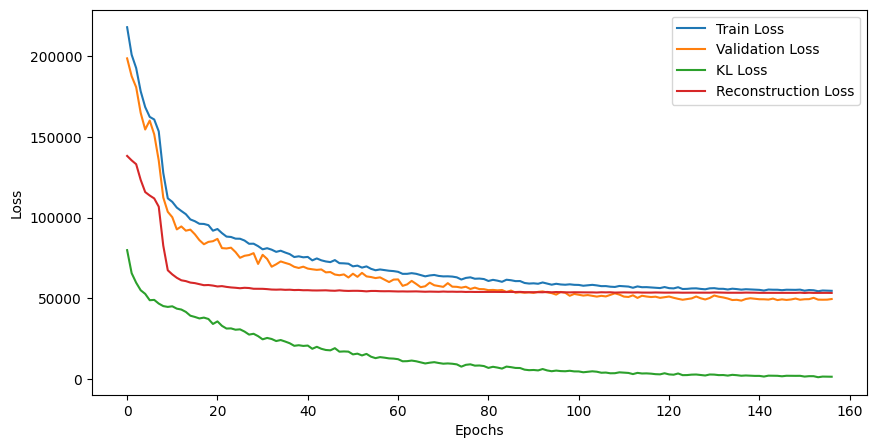

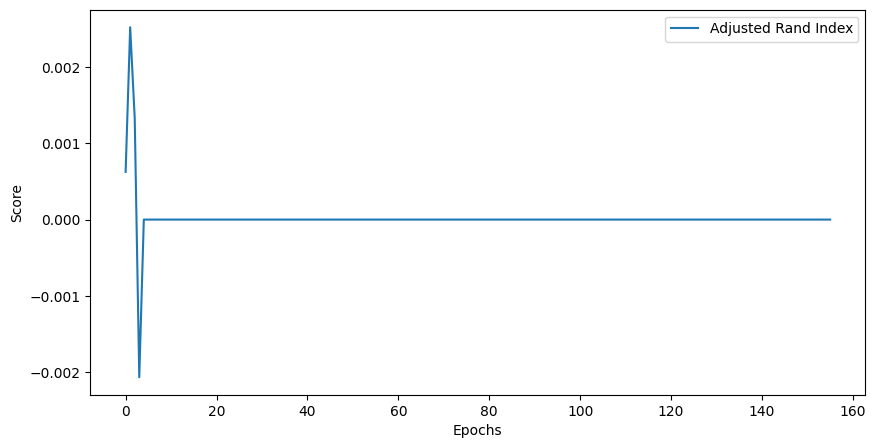

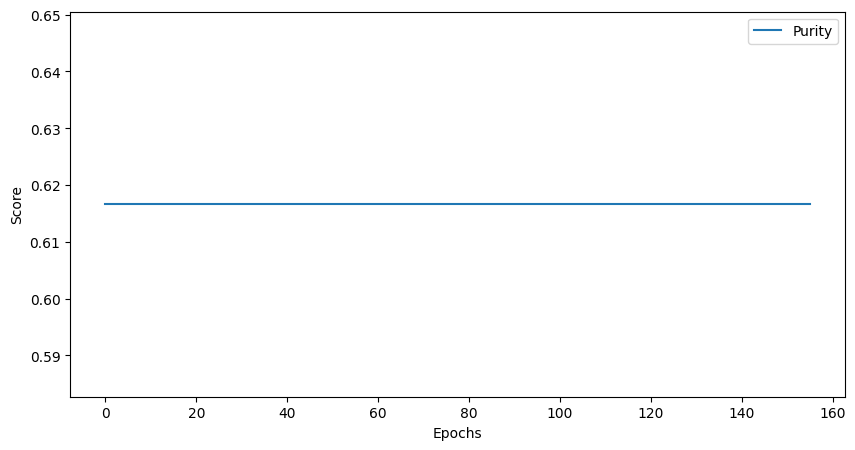

In [3]:
from models import variational
from models import train_vade, evaluate

encoder = variational.Encoder(num_layers, poolsize, channels,
                          kernel_sizes, dilations, activations)
decoder = variational.Decoder(encoder)
model = variational.DeepEmbedding(encoder, decoder, 15)

train_vade(model, train_data, val_data,
      lr=learning_rate,
      batch_size=batch_size,
      epochs=epochs)
# model.load_state_dict(torch.load('./saved_models/variational_model.pt'))
# evaluate(model, test_data,
#         batch_size=batch_size)

torch.save(model, './saved_models/vade_model.pt')

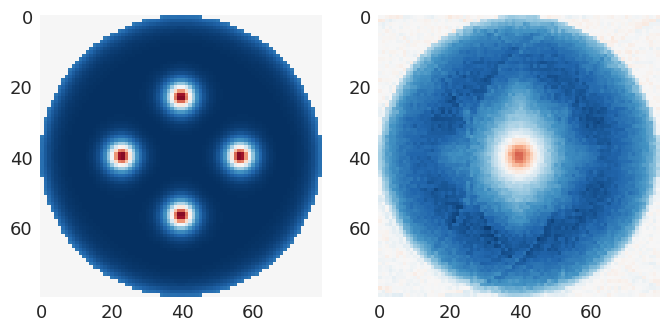

In [10]:
from plot import random_recon
random_recon(model, test_data)

In [11]:
from sklearn.cluster import HDBSCAN
from cluster_acc import purity, adj_rand_index

feature_array = model.feature_array(sim_arr_tensor)

clustering = HDBSCAN(min_cluster_size=5, cluster_selection_epsilon=0.1).fit(feature_array)
labels = clustering.labels_

print(f'Purity: {purity(labels)}')
print(f'ARI: {adj_rand_index(labels)}')

Purity: 0.6166112956810631
ARI: -0.006144467908619453


In [12]:
from cluster_acc import adj_rand_index, purity

print("Adjusted Rand Index: ", adj_rand_index(labels))
print("Purity: ", purity(labels))

Adjusted Rand Index:  -0.006144467908619453
Purity:  0.6166112956810631


In [15]:
import json
import plotly.express as ptx
import plotly.graph_objs as go


print(len(set(labels)) - (1 if -1 in labels else 0))
with open('./data/parameters_dict.json', 'r', encoding='utf-8') as f:
    parameters_dict = json.load(f)
with open('./data/simulation_file_paths.json', 'r', encoding='utf-8') as f:
    simulation_file_paths = json.load(f)


class_dict = {f"Class {i}": list() for i in range(len(set(labels)))}
class_dict["Outliers"] = list()
for index, path in enumerate(simulation_file_paths):
    class_ = labels[index]
    if class_ == -1:
        class_dict["Outliers"].append(str(path))
    else:
        class_dict[f"Class {class_}"].append(str(path))

traces = list()
for class_id, colour in zip(class_dict, ptx.colors.qualitative.Dark24):
    traces.append(
        go.Scatter(
            x=[
                parameters_dict[f]["H"]
                for f in class_dict[class_id]
            ],
            y=[
                parameters_dict[f]["E"]
                for f in class_dict[class_id]
            ],
            mode="markers",
            name=class_id,
            opacity=0.7,
            marker=dict(
                size=11,
                color=colour,
            ),
        )
    )

fig = go.Figure(data=traces)
fig.update_layout(
    autosize=False,
    width=990,
    height=600,
    margin=dict(
        l=10,
        r=10,
        b=25,
        t=25,
    ),
    xaxis_title=r"$\mu_0 \mathbf{H} \text{ (T)}$",
    yaxis_title=r"$\Delta \text{E (J)}$",
)

2


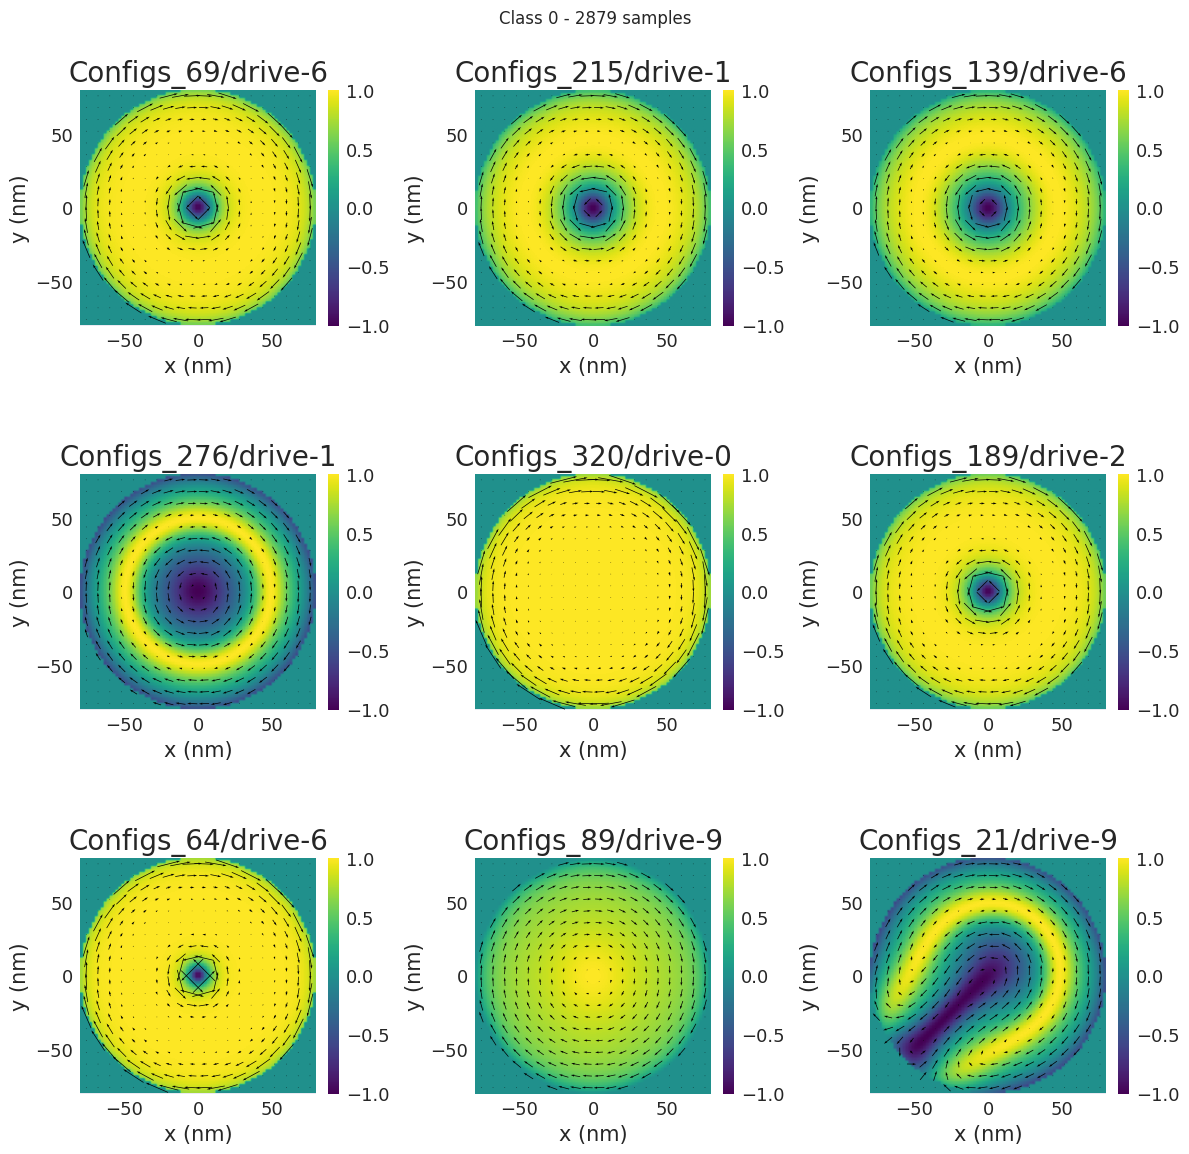

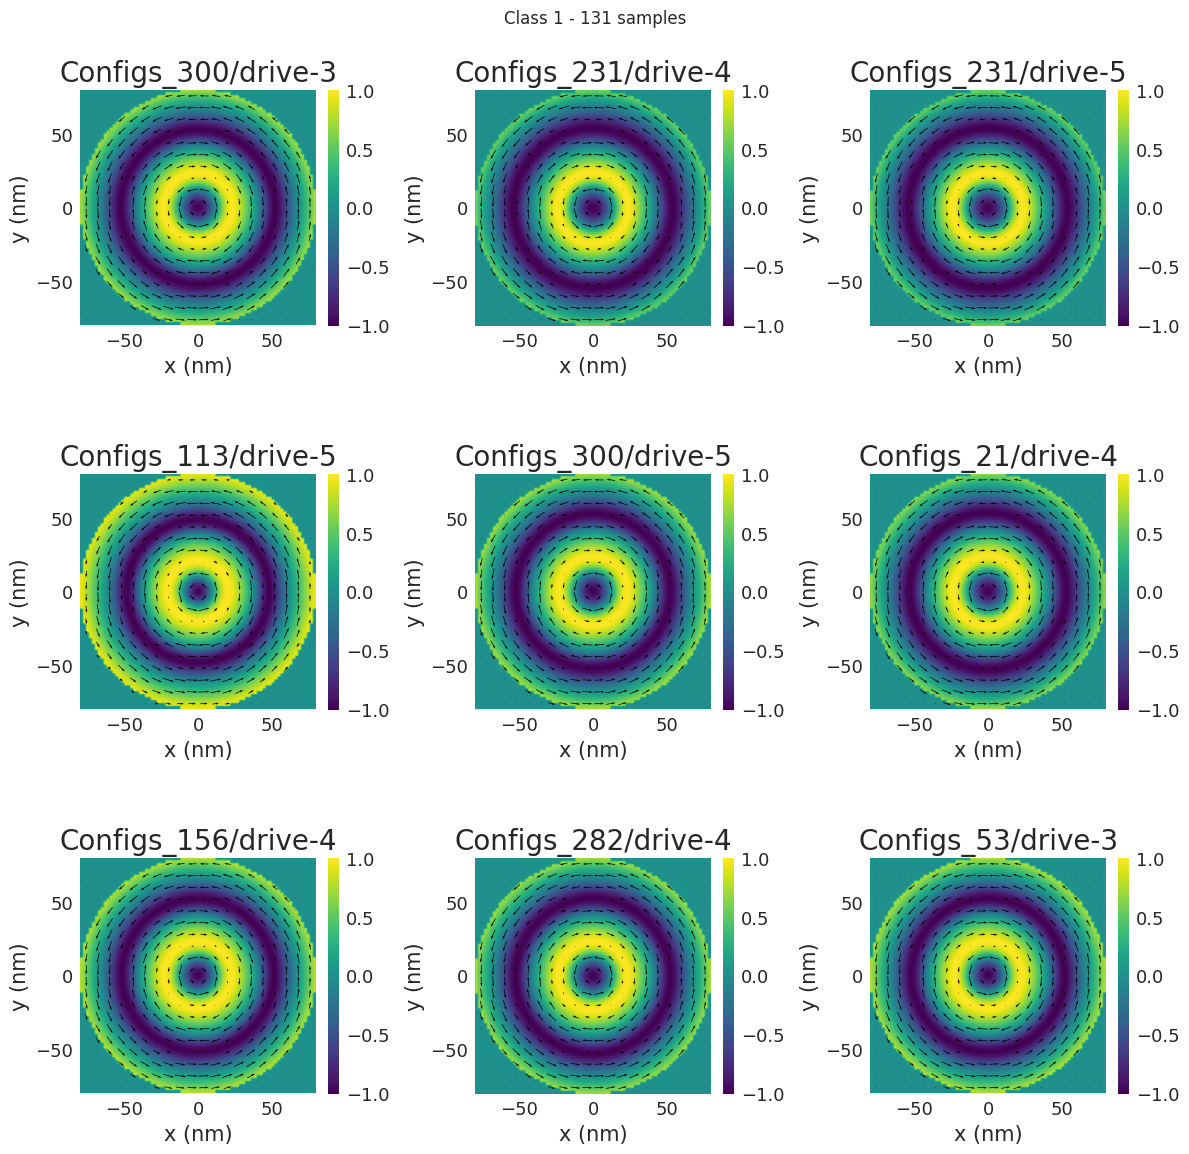

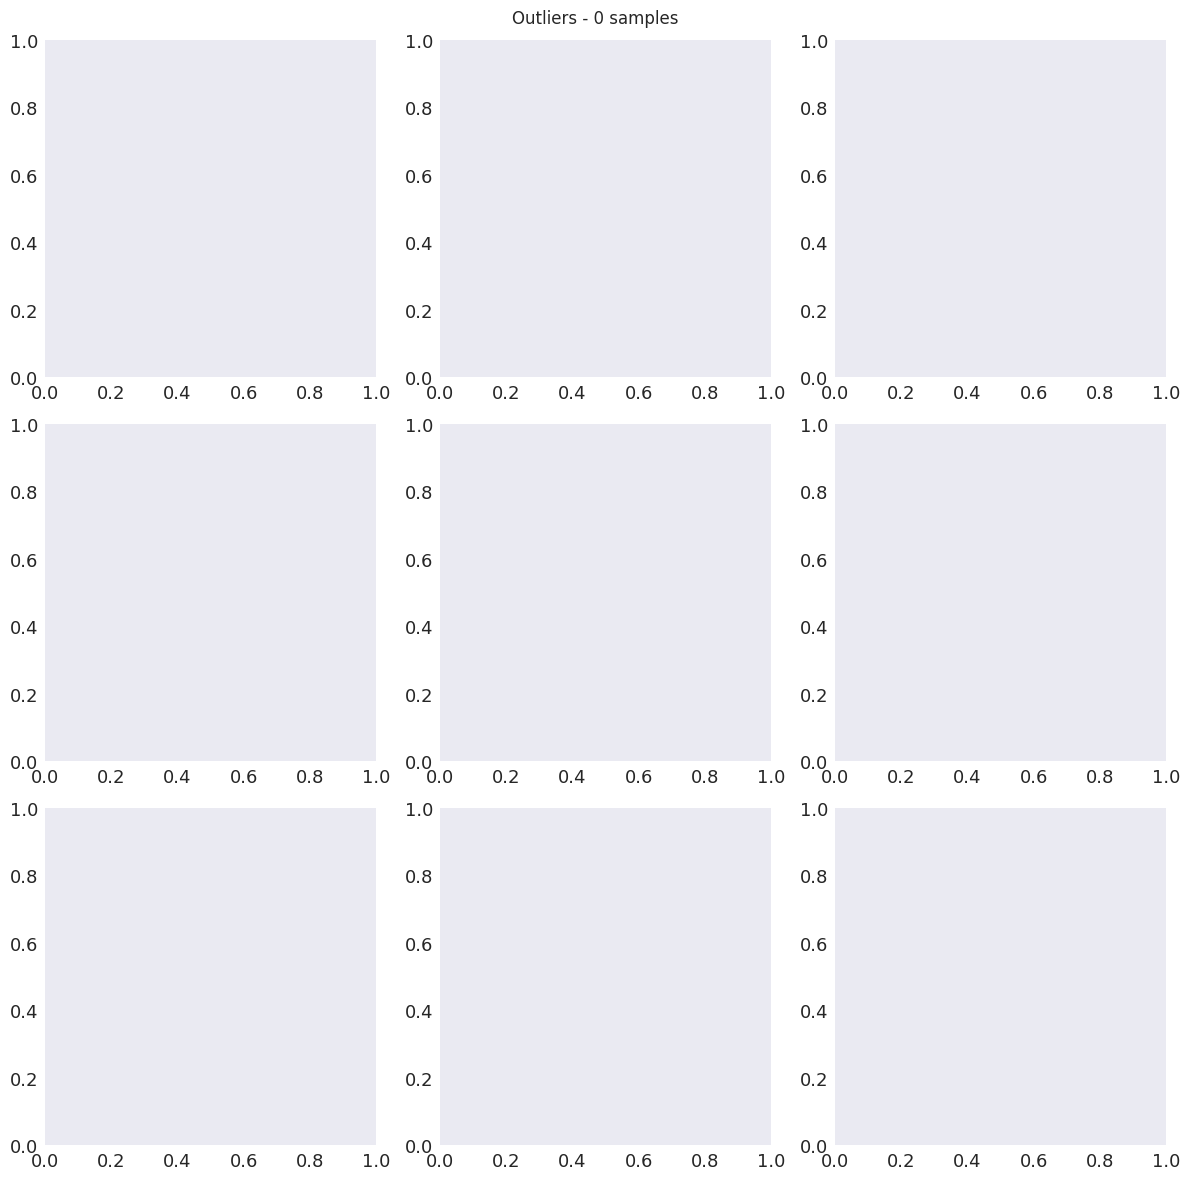

In [18]:
from plot import plot_all_examples

plot_all_examples(labels)